<a href="https://colab.research.google.com/github/nitrohelix1/jupyter-exploration/blob/main/Student_Notebook_LAB_Object_Detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Object Detection using TensorFlow and COCO Dataset

In this exercise, we will adapt our image classification task to an object detection task. Object detection involves not only classifying objects within an image but also localizing them with bounding boxes.

Note: Due to the limited computational resources available, we'll be using a smaller subset of the COCO dataset and a lightweight object detection model. This might result in lower accuracy, but the focus of this exercise is on understanding the concepts and workflow of object detection.

## Steps:
1. Install (if necessary) and Import the libraries you will need for this project
2. Load the COCO dataset
3. Use a pre-trained object detection model (SSD MobileNet V2)
4. Display detected objects with bounding boxes
    

In [ ]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib


In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1



### Load the COCO dataset

We will use the COCO 2017 dataset, which contains images with annotations for object detection. For demonstration purposes, we will load a small subset of the dataset using TensorFlow Datasets.

- COCO (Common Objects in Context) is a large-scale object detection, segmentation, and captioning dataset.
- We define a function load_data to load the COCO dataset.
- tfds.load is a function that downloads and prepares the dataset.
- We use only 1% of the training data to keep the demonstration manageable.
- shuffle_files=True ensures that we get a random sample of the dataset.
- with_info=True returns additional information about the dataset, which we'll use later.
- The COCO (Common Objects in Context) dataset contains 80 object categories. Here is the list of classes in the COCO dataset:
    - person, bicycle, car, motorcycle,airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign,parking meter, bench, bird, cat, dog, horse, sheep,
    cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove,skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, TV, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock,vase, scissors, teddy bear, hair drier, toothbrush
    

In [ ]:
import tensorflow_datasets as tfds

# Load the COCO dataset
def load_data(split='train'):
    dataset, info = tfds.load('coco/2017', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Correctly load the dataset  and extract dataset_info Using only a subset for demonstration
train_dataset, train_info = load_data('train[:1%]')

# Load the validation (test) dataset
validation_dataset, validation_info = load_data('validation[:1%]')

### When To Load the model
Loading the model early (right after dataset loading):

Pros: Model is immediately available; clear separation of setup and processing.
Cons: Potentially inefficient if data prep is extensive or fails.


Loading the model after data preparation:

Pros: More efficient resource use; avoids unnecessary loading if data prep fails.
Cons: Model isn't available for any data prep steps that might need it.


In our specific case, loading the model after data preparation is slightly better because:

Our data prep doesn't need the model.
It's more resource-efficient.
It follows a logical flow: prepare data, load tools, process data.
It avoids unnecessary model loading if data prep fails.

However, the difference is minimal in this small-scale example. For beginners, loading major components upfront can sometimes be clearer and easier to follow.
As a best practice, aim to load your model as close as possible to where you'll use it, ensuring all necessary data and resources are ready first.

In [ ]:
#Load a pre-trained object detection model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

Let's break this down:

- 1. hub.load(): This function is from TensorFlow Hub (tensorflow_hub). It downloads and loads models from the TensorFlow Hub repository.
- 2. "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2": This is the URL of the specific model we're loading. It's an SSD (Single Shot Detector) MobileNet V2 model, which is efficient for object detection tasks.
- 3. Detector: The loaded model is assigned to this variable. It becomes a callable object that you can use for object detection.

Advantages of this approach:

Concise and readable
Directly loads the model without additional wrapper functions
TensorFlow Hub handles caching, so subsequent loads will be faster

### Find Images with Specific Classes

We get the list of all class names in the COCO dataset.
We define our target classes (bicycle, car, person) and find their corresponding IDs.
We create a function to find images containing our target classes.
We use this function to select a few relevant images from our dataset.

In [ ]:
import random

# Get COCO class names
dataset_info = train_info
class_names = dataset_info.features['objects']['label'].names

#Define Class IDs for the classes we are interested in
target_class_ids = [1, 2, 3, 18, 64]  # Replace with the desired class IDs
info = train_info

# Function to find images with specific classes
def find_images_with_classes(dataset, class_ids, num_images=5):
    images = []
    for example in dataset:
        labels = example['objects']['label'].numpy()
        if any(class_id in labels for class_id in class_ids):
            images.append(example)
        if len(images) >= num_images:
            break
    return images


# Find images with our target classes
target_images = find_images_with_classes(train_dataset, target_class_ids)

# Print the number of images found
print(f"Found {len(target_images)} images with target classes.")



Found 5 images with target classes.


### Display Random Images with Class Labels

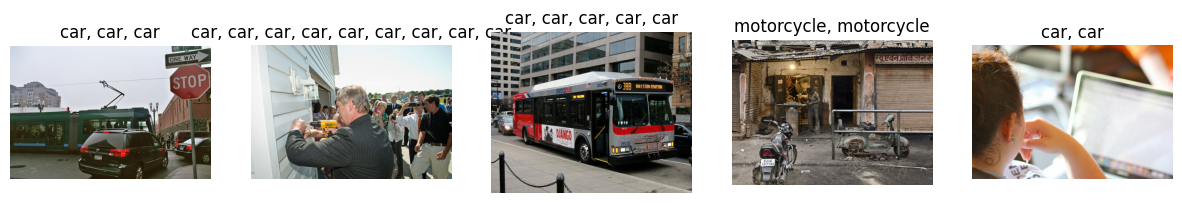

In [ ]:
# Display random 5 images to check if they load correctly
def display_images(images, class_names, target_class_ids):
    plt.figure(figsize=(15, 10))
    for i, example in enumerate(images):
        image = example['image'].numpy()
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        title = ", ".join([class_names[label] for label in example['objects']['label'].numpy() if label in target_class_ids and label < len(class_names)])
        plt.title(title)
        plt.axis('off')
    plt.show()

# Select random 5 images
if target_images:
    random_images = random.sample(target_images, min(5, len(target_images)))
    display_images(random_images, class_names, target_class_ids)
else:
    print("No images found with the specified target classes.")


### Helper Function to Display Bounding Boxes on Images

The `display_image_with_boxes` function takes an image, bounding boxes, and class names, then displays the image with bounding boxes drawn around detected objects.
- run_detector: This function prepares an image and runs it through our object detection model.
- plot_detections: This function visualizes the detected objects by drawing bounding boxes and labels on the image.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

In [ ]:
# Function to run the object detector
def run_detector(detector, img):
    # Ensure the image is of type uint8 and has the correct shape
    img = tf.convert_to_tensor(img, dtype=tf.uint8)
    img = tf.expand_dims(img, axis=0)

    result = detector(img)
    result = {key: value.numpy() for key, value in result.items()}
    return result

# Function to plot detections
def plot_detections(image, detections, class_names, threshold=0.5):
    plt.figure(figsize=(16, 12))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Detections
    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.title("Detections")

    # Create a color map for different classes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

    for i, score in enumerate(detections['detection_scores'][0]):
        if score > threshold:
            ymin, xmin, ymax, xmax = detections['detection_boxes'][0][i]
            class_id = int(detections['detection_classes'][0][i])
            class_name = class_names[class_id] if class_id < len(class_names) else 'Unknown'
            color = colors[class_id % len(colors)]

            # Draw bounding box
            rect = patches.Rectangle(
                (xmin * image.shape[1], ymin * image.shape[0]),
                (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            plt.gca().add_patch(rect)

            # Add label
            plt.text(
                xmin * image.shape[1], ymin * image.shape[0] - 5,
                f'{class_name}: {score:.2f}',
                bbox=dict(facecolor=color, alpha=0.8), fontsize=8, color='white'
            )

    plt.axis('off')

    # Heatmap
    plt.subplot(2, 2, 3)
    heatmap = np.zeros((image.shape[0], image.shape[1]))
    for i, score in enumerate(detections['detection_scores'][0]):
        if score > threshold:
            ymin, xmin, ymax, xmax = detections['detection_boxes'][0][i]
            heatmap[int(ymin * image.shape[0]):int(ymax * image.shape[0]),
                    int(xmin * image.shape[1]):int(xmax * image.shape[1])] += score

    plt.imshow(heatmap, cmap='hot', alpha=0.7)
    plt.title("Detection Heatmap")
    plt.axis('off')

    # Class distribution
    plt.subplot(2, 2, 4)
    class_counts = {}
    for i, score in enumerate(detections['detection_scores'][0]):
        if score > threshold:
            class_id = int(detections['detection_classes'][0][i])
            class_name = class_names[class_id] if class_id < len(class_names) else 'Unknown'
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    plt.bar(class_counts.keys(), class_counts.values(), color=colors[:len(class_counts)])
    plt.title("Detected Class Distribution")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()


###  Process and Display Images with Detections
The `detect_and_display` function runs object detection on an image and displays the results, as you saw above. The function converts the image to the appropriate format, runs the detector, and then uses the helper function to display the results.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.


Processing sample image 1


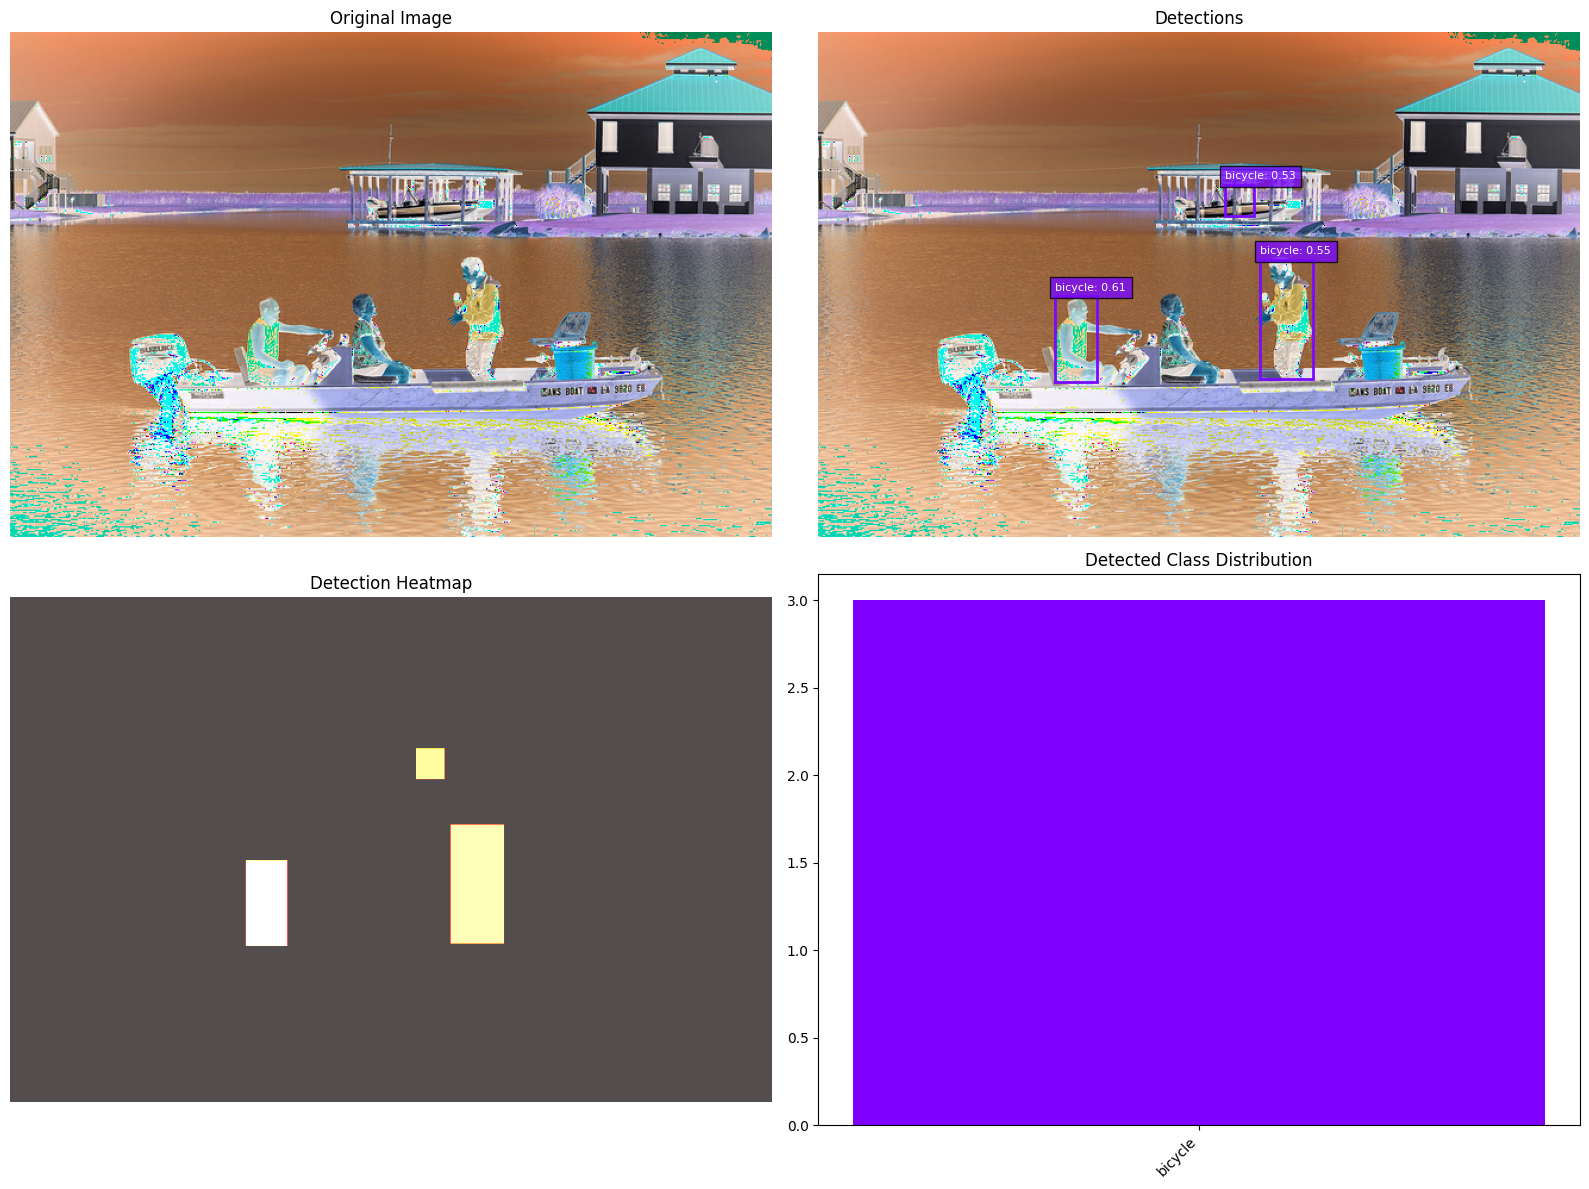


Processing sample image 2


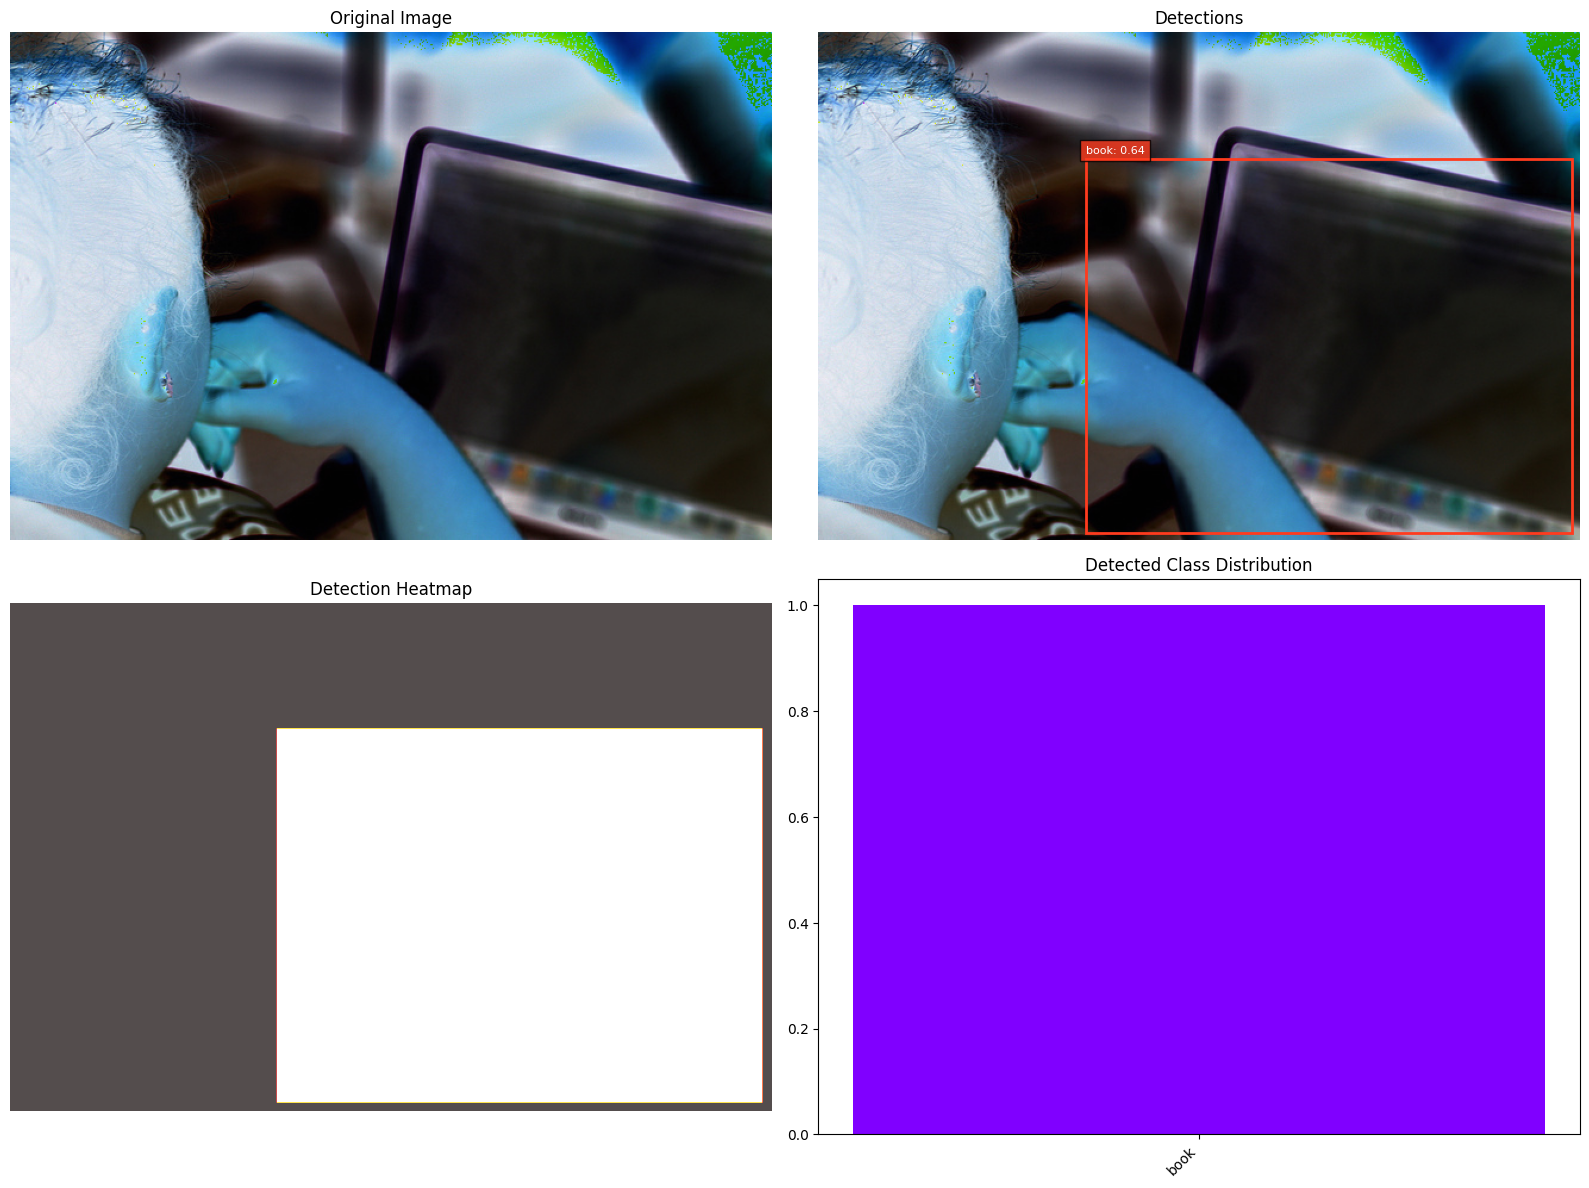


Processing sample image 3


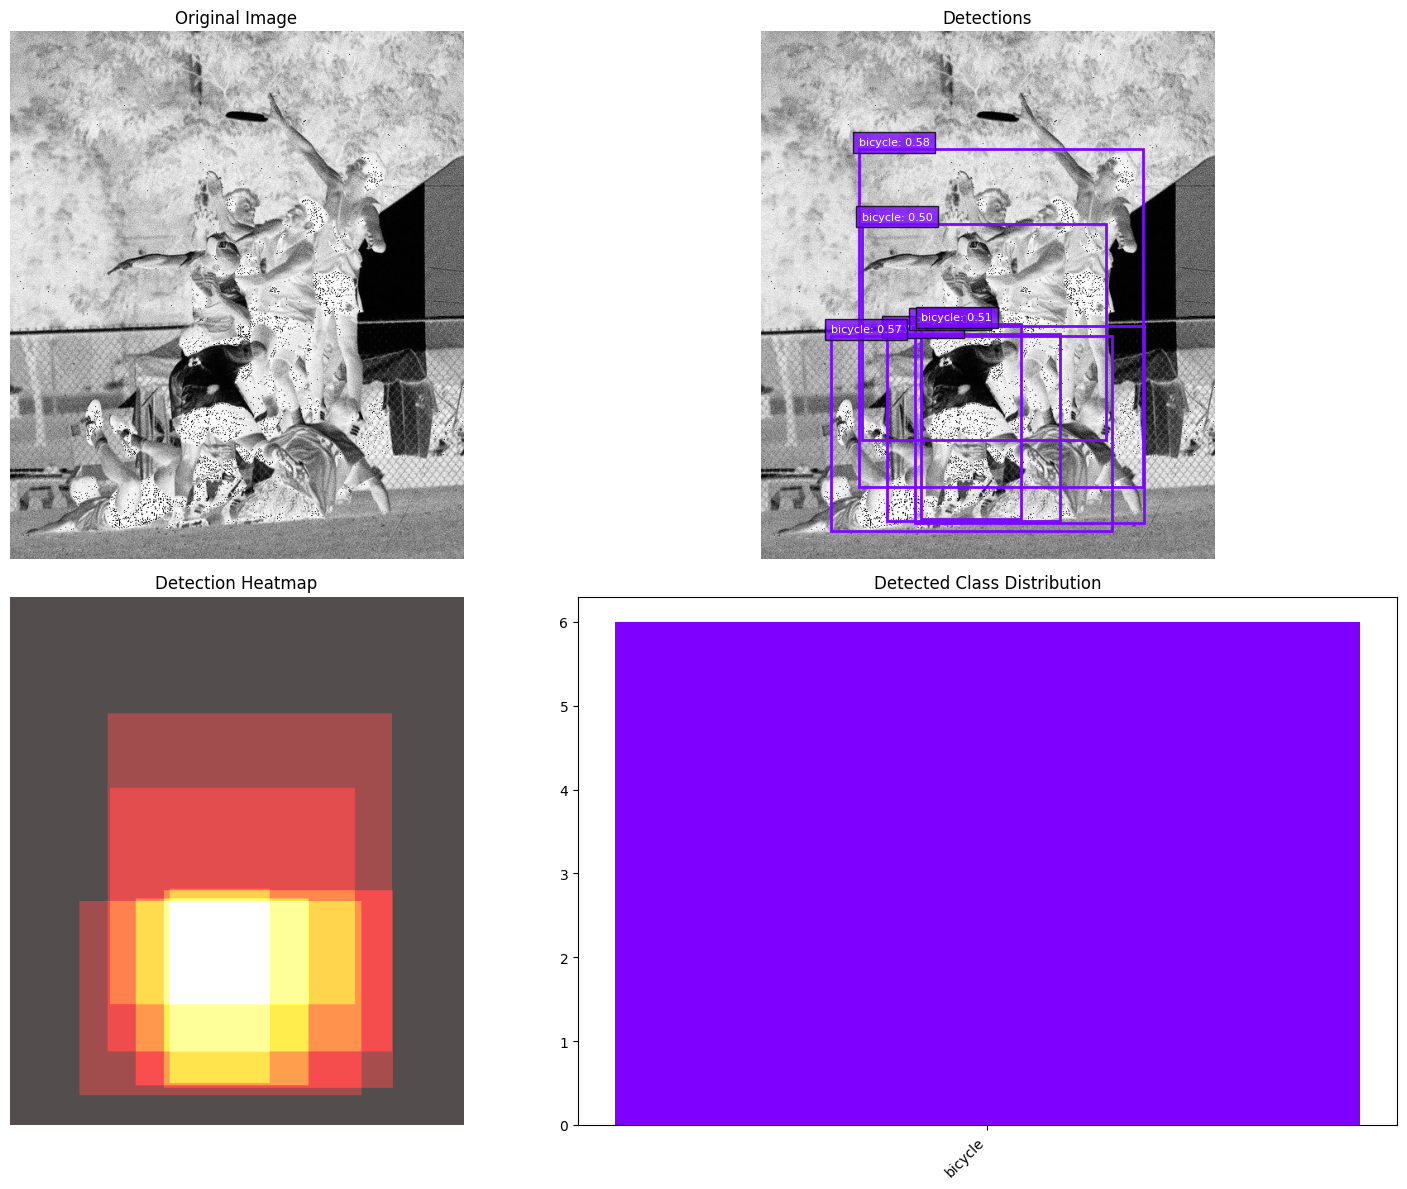

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to process and display images with detections
def process_and_display_images(dataset, detector, class_names, num_images=3):
    for i, example in enumerate(dataset.take(num_images)):
        print(f"\nProcessing sample image {i+1}")
        image = example['image'].numpy()
        image = (image * 255).astype(np.uint8)  # Convert image to uint8
        detections = run_detector(detector, image)
        plot_detections(image, detections, class_names)

# Run the function to process and display images with detections
process_and_display_images(train_dataset, detector, class_names)


 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.


Processing sample images from the dataset:

Sample image 1


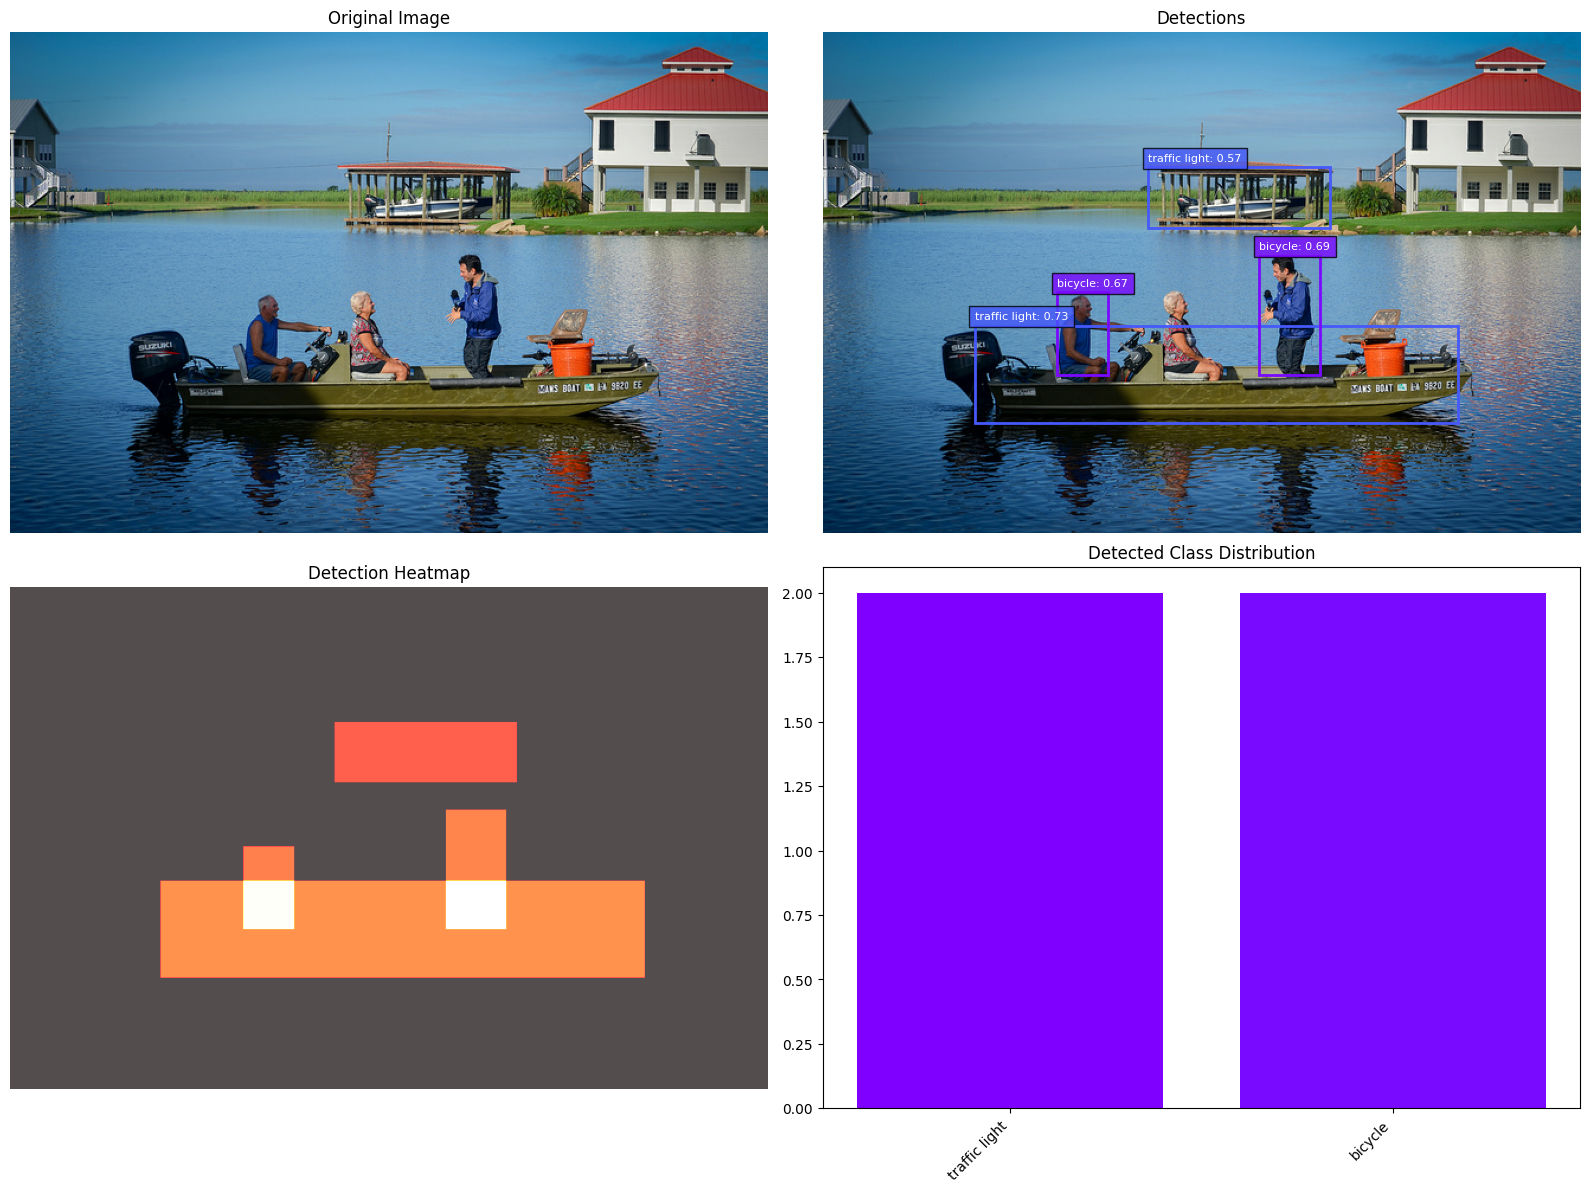


Sample image 2


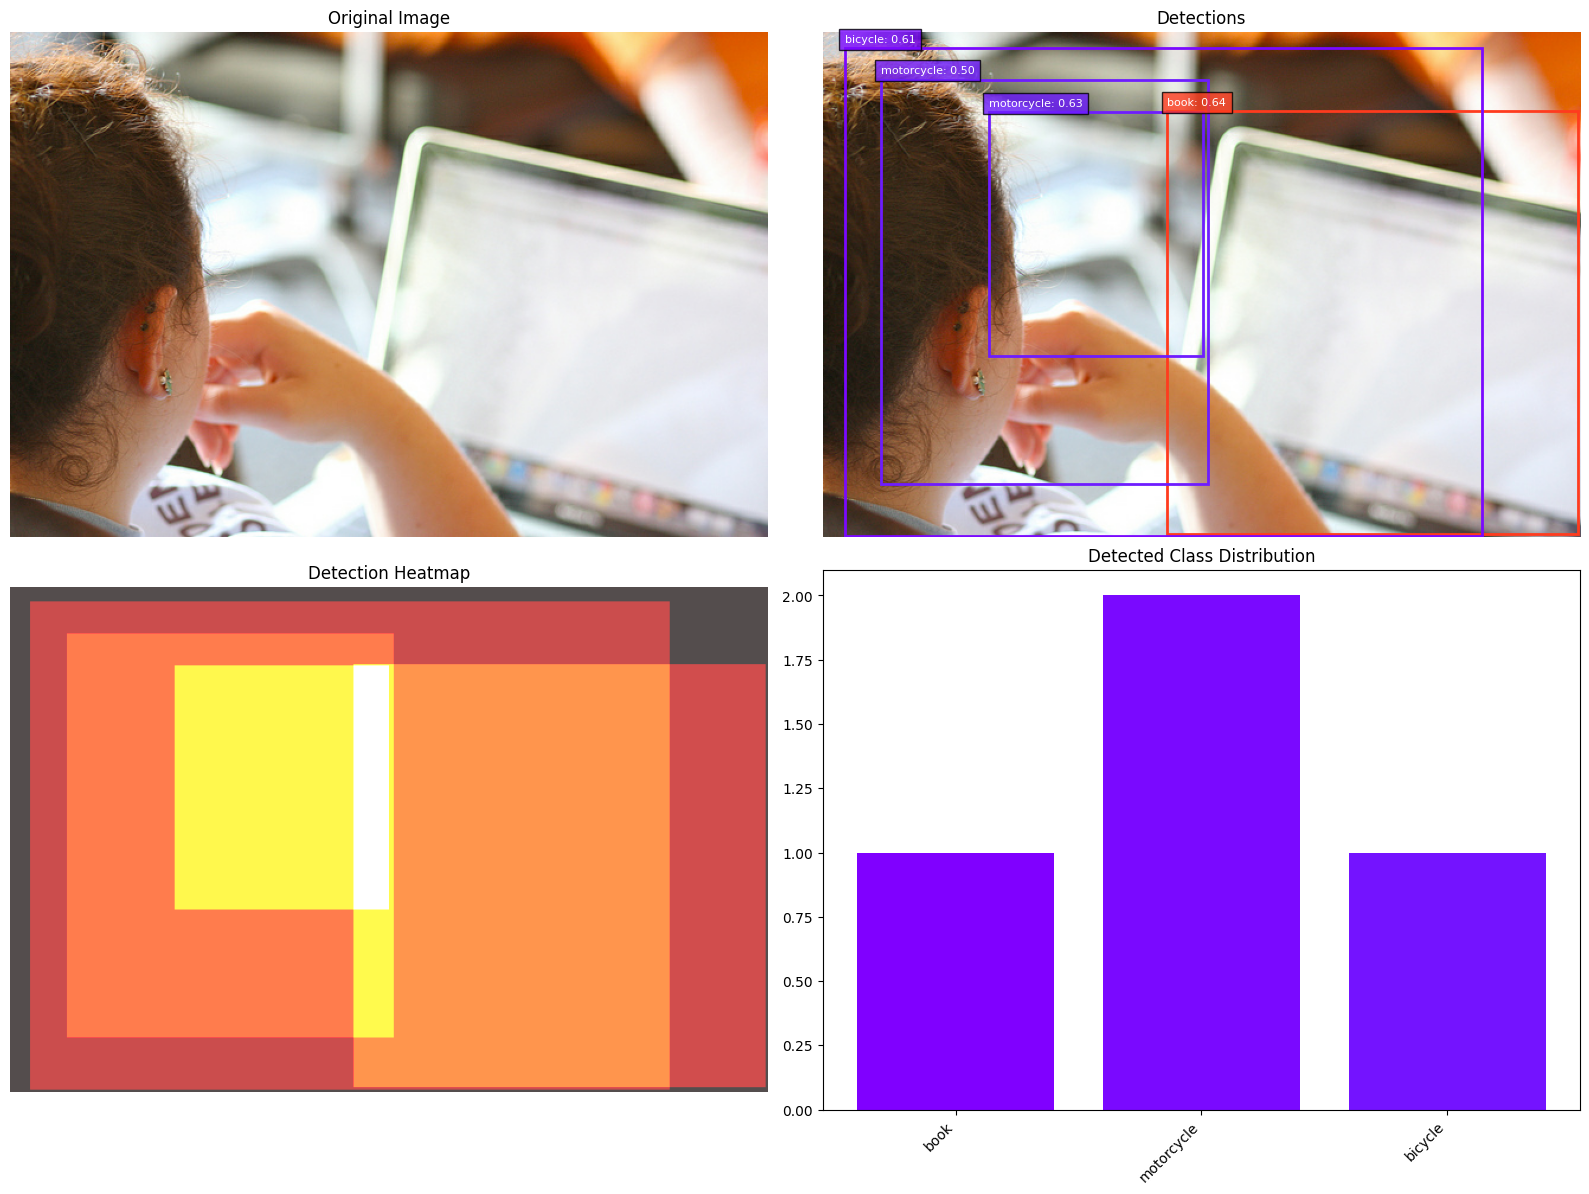


Sample image 3


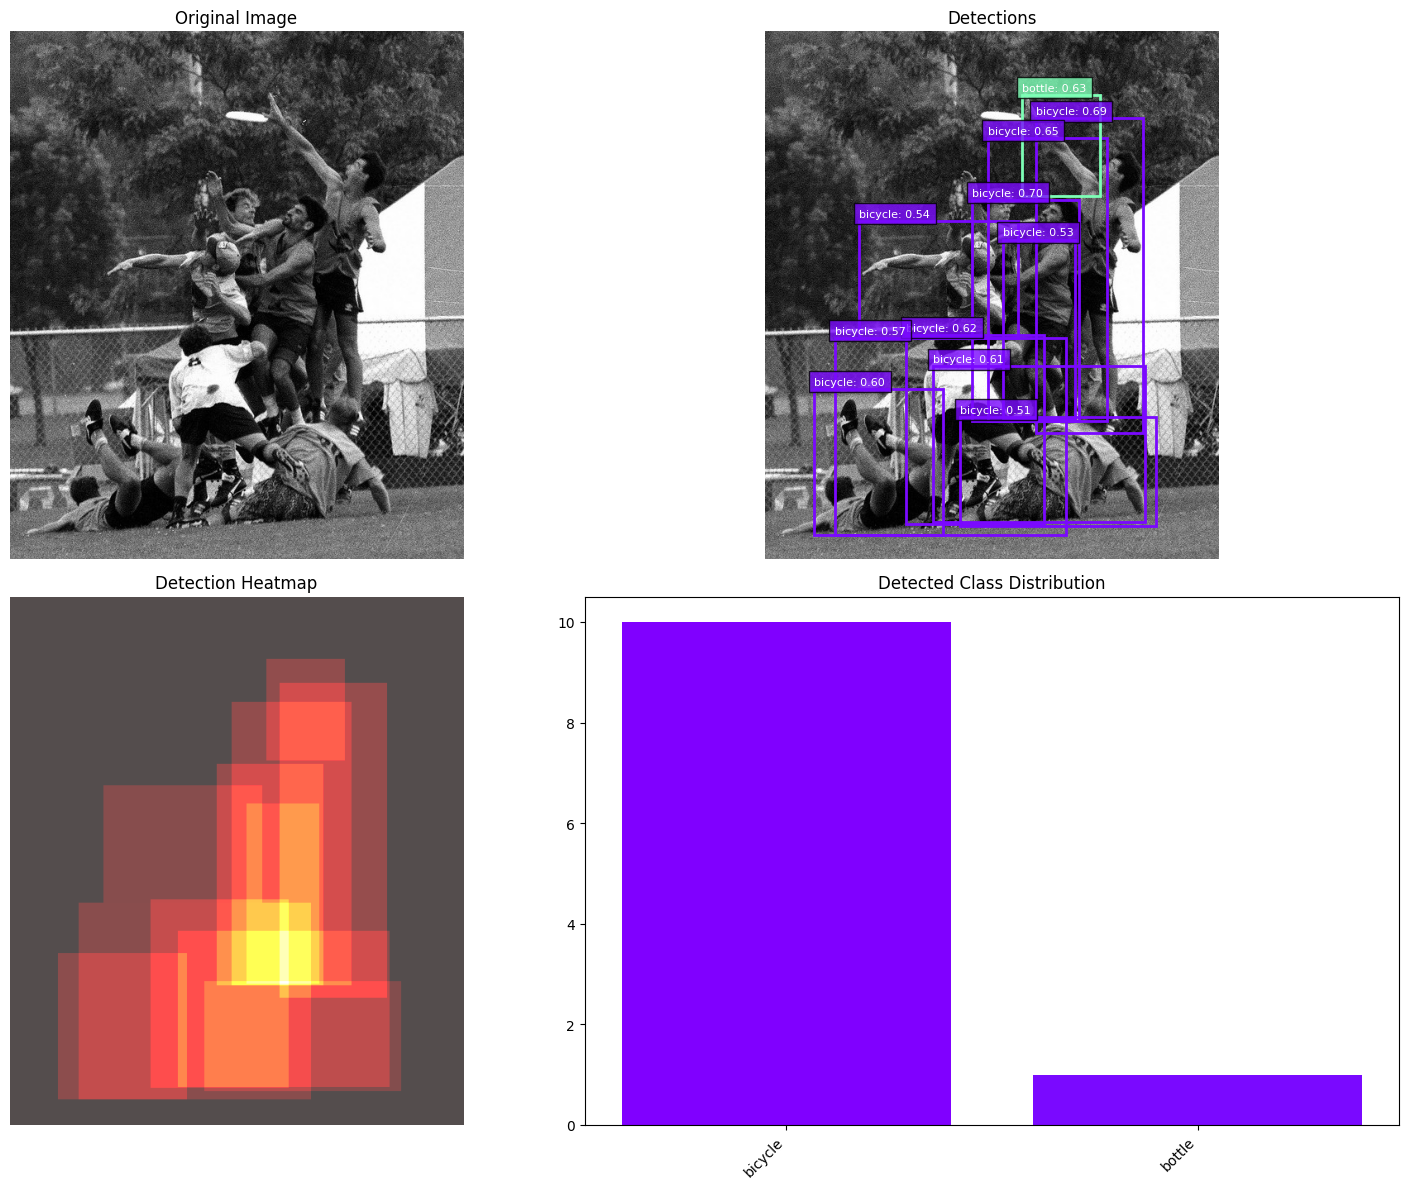

In [ ]:
# Process a few images from the dataset
print("\nProcessing sample images from the dataset:")
for i, example in enumerate(train_dataset.take(3)):
    print(f"\nSample image {i+1}")
    image = example['image'].numpy()
    detections = run_detector(detector, image)
    plot_detections(image, detections, class_names)


## Mode Evaluation
###  Define the Evaluation Function

 The function called evaluate_model_performance which evaluates the performance of our object detection model on a dataset. The function takes three arguments: the dataset to evaluate on, the object detection model, and the number of images to use for evaluation. It calculates and prints the accuracy of the model based on the detections.   

In [ ]:
# Evaluate model performance
def evaluate_model_performance(dataset, detector, num_samples=100):
    total_detections = 0
    correct_detections = 0

    for i, example in enumerate(dataset.take(num_samples)):
        image = example['image'].numpy()
        image = (image * 255).astype(np.uint8)  # Convert image to uint8
        labels = example['objects']['label'].numpy()
        detections = run_detector(detector, image)

        for i, score in enumerate(detections['detection_scores'][0]):
            if score < 0.5:
                continue

            detected_class = int(detections['detection_classes'][0][i])
            if detected_class in labels:
                correct_detections += 1

            total_detections += 1

    accuracy = correct_detections / total_detections if total_detections > 0 else 0
    print(f"Model Performance:")
    print(f"Total detections: {total_detections}")
    print(f"Correct detections: {correct_detections}")
    print(f"Accuracy: {accuracy:.2f}")

# Evaluate model performance
print("Evaluating model performance...")
evaluate_model_performance(train_dataset, detector)


Evaluating model performance...
Model Performance:
Total detections: 227
Correct detections: 12
Accuracy: 0.05


### Upload your Image
This final block allows you to input your own image URL for object detection, making the exercise interactive.


 ### Instructions  to Upload Your Own Images

In [ ]:
# Instructions for students to upload their own images
print("\nTo upload your own image for object detection:")
print("1. If using Google Colab, use:")
print("   from google.colab import files")
print("   uploaded = files.upload()")
print("   image_data = next(iter(uploaded.values()))")
print("2. Then run:")
print("   process_uploaded_image(image_data)")



To upload your own image for object detection:
1. If using Google Colab, use:
   from google.colab import files
   uploaded = files.upload()
   image_data = next(iter(uploaded.values()))
2. Then run:
   process_uploaded_image(image_data)


### Conclusion
This exercise introduces you to object detection while keeping computational requirements relatively low. It uses a pre-trained model, so no training is required, making it suitable for systems with limited resources.

Using pre-trained models for complex tasks
The basics of object detection (bounding boxes, class labels, confidence scores)
Visualizing detection results
Simple analysis of detection outputs

The exercise is also interactive, allowing students to try object detection on their own chosen images. Copy

## Questions for Reflection and Analysis:
1. **Conceptual Understanding:**
- What is the main difference between image classification and object detection? How is this difference evident in the output of this exercise?
- Explain why we chose the SSD MobileNet V2 model for this task. What are its advantages and limitations, especially in the context of limited computational resources?

2. **Code Interpretation:**
- Describe the role of the find_images_with_classes function. Why is it useful when working with a large dataset like COCO?
- In the plot_detections function, how does the threshold value (threshold=0.5) impact the number of objects displayed?
- Explain how the heatmap visualization helps you understand the model's confidence in its detections.

3. **Observing Results and Limitations:**
- Run the exercise multiple times. Which types of objects does the model tend to detect more accurately? Which ones are more challenging? Can you explain why?
- Observe the bounding boxes. Are there any instances where the boxes are inaccurate or miss the object entirely? What factors in the images might be contributing to these errors?
- How would you expect the accuracy of the model to change if we had used the entire COCO dataset instead of a small subset? Why?

4. **Critical Thinking:**
- How could you modify the code to detect a specific set of objects, like only animals or only vehicles?
- If you wanted to train your own object detection model, what steps would you need to take? What are some challenges you might encounter?
- Given the limitations of this model, in what real-world scenarios might it still be useful for object detection?

5. **Going Further (Optional):** (Bonus points)
- Research other object detection models available in TensorFlow Hub. Compare and contrast them with SSD MobileNet V2 in terms of accuracy, speed, and resource requirements.
- Try running a few images through a more powerful object detection model online (if available). Compare the results to the output of this exercise. What differences do you notice?
- Important: Remember, the goal here isn't perfect accuracy. It's to understand the core concepts of object detection, the limitations of working with restricted resources, and how to critically analyze the results.